In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
from utils import plot_results

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)

    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)

    center, radius = get_infection_site(Cp_file)

    return Cp, Cl, center, radius

In [4]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

## Formatting input parameters

In [5]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)

In [6]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1



## Input verification

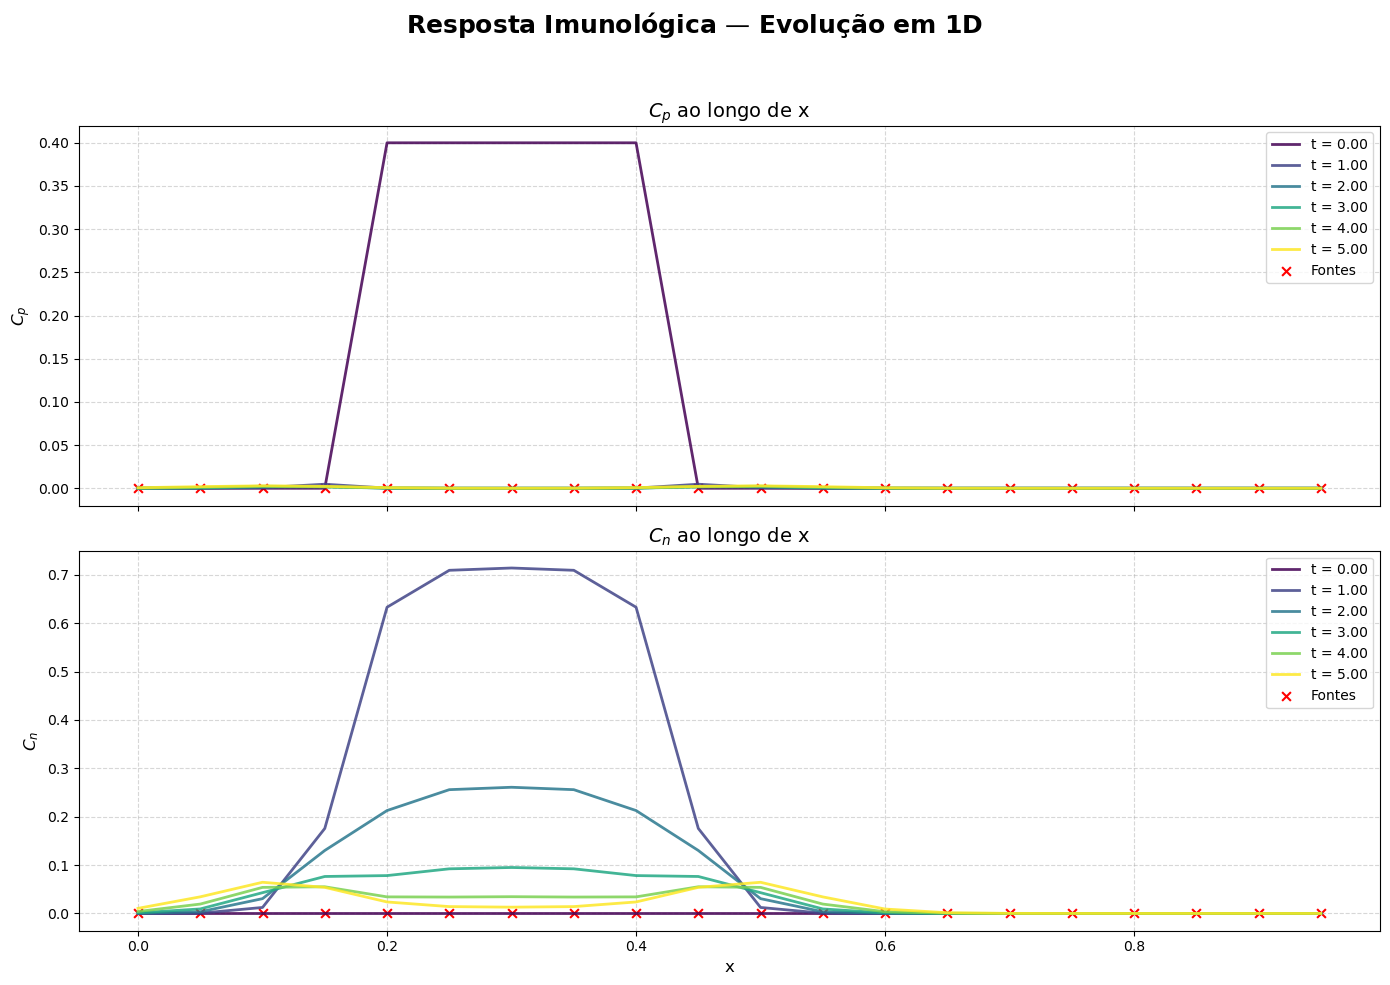

In [7]:
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

plot_results(size_t,size_x,t_dom,x_dom,Cp_fvm,Cl_fvm,leu_source_points)

## Allocate GPU memmory

In [8]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):

        reduced_Cl[i, :] = Cl[idx, :, :]

        reduced_Cp[i, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [9]:
size = 4
source = leu_source_points

x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size, endpoint=False, dtype=np.float32
    )

x_idx = np.linspace(0, size, num=size, endpoint=False, dtype=int)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size, endpoint=True, dtype=np.float32)

x_idx_mesh, t_mesh = np.meshgrid(
    x_idx,
    t_np,
)

x_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]

x_mesh = np.zeros_like(t_mesh)
source_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]
source_mesh = source[x_idx_mesh.ravel()]


In [10]:
def create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples=None):

    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    x_idx = np.linspace(0, size_x, num=size_x, endpoint=False, dtype=int)

    if n_samples:

        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

        x_idx_mesh, t_mesh = np.meshgrid(
            x_idx,
            t_np,
        )

        x_mesh = np.zeros_like(t_mesh)
        source_mesh = np.zeros_like(t_mesh)

        x_mesh = x_np[x_idx_mesh.ravel()]
        source_mesh = source[x_idx_mesh.ravel()]

        return (
            reduced_Cl,
            reduced_Cp,
            t_mesh,
            x_mesh,
            source_mesh,
        )

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)

    x_idx_mesh, t_mesh = np.meshgrid(
        x_idx,
        t_np,
    )

    x_mesh = np.zeros_like(t_mesh)
    source_mesh = np.zeros_like(t_mesh)

    x_mesh = x_np[x_idx_mesh.ravel()]
    source_mesh = source[x_idx_mesh.ravel()]

    return (
        t_mesh,
        x_mesh,
        source_mesh,
    )

In [11]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center_x,
    initial_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples=None,
):

    (
        t_mesh,
        x_mesh,
        src_mesh,
    ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    
    src_tc = torch.tensor(src_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:

        (
            reduced_Cl,
            reduced_Cp,
            reduced_t_mesh,
            reduced_x_mesh,
            reduced_src_mesh,
        ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples)

        reduced_t_tc = (
            torch.tensor(reduced_t_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_x_tc = (
            torch.tensor(reduced_x_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_src_tc = (
            torch.tensor(reduced_src_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            t_tc,
            x_tc,
            src_tc,
            target,
            reduced_t_tc,
            reduced_x_tc,
            reduced_src_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            t_tc,
            x_tc,
            src_tc,
            target,
            device,
        )

In [12]:
n_samples = 1
(
    initial_tc,
    center_x_tc,
    radius_tc,
    t_tc,
    x_tc,
    src_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_src_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples,
)

device: cuda


## Allocation validation

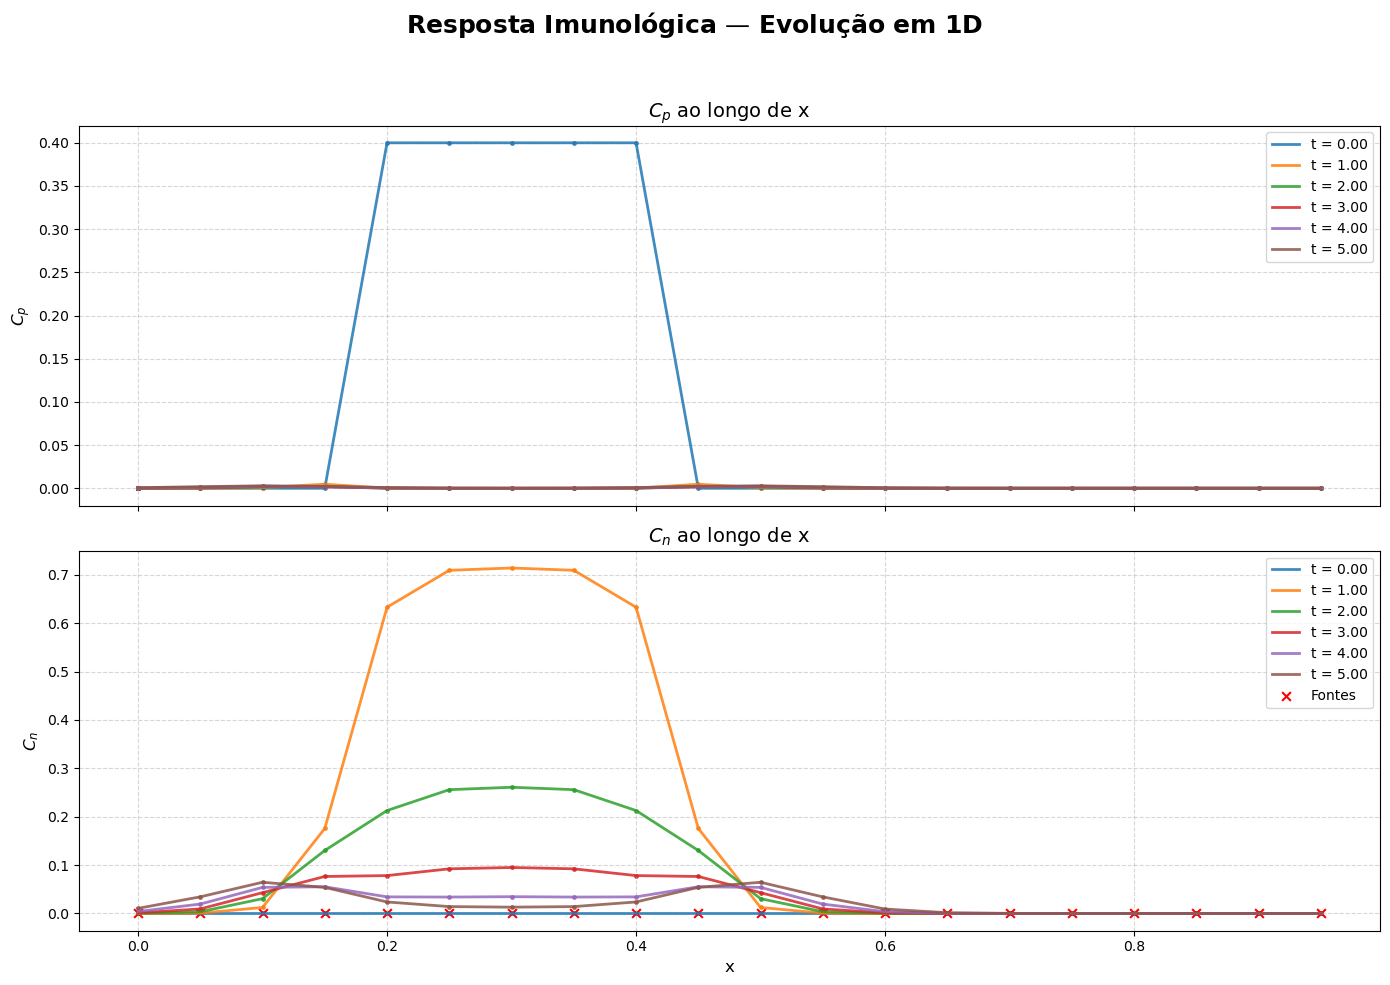

In [13]:
Cl_tc, Cp_tc = target.split(1, dim=1)

Cl = Cl_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

# t_np, x_np, Cp, Cl, source_index already defined
# source_index is assumed to be an array of x positions only (1D or Nx1)

time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fig.suptitle(
    "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
)

source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()


for i, time_inst in enumerate(time_plot):
    axes[0].plot(
        x_np,
        Cp[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(t_tc.detach().numpy() == t_np[time_inst]).ravel()

    axes[0].scatter(
        x_tc[time_ft].detach().numpy(),
        Cp_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
axes[0].set_ylabel("$C_p$", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Cl
for i, time_inst in enumerate(time_plot):
    axes[1].plot(
        x_np,
        Cl[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(t_tc.detach().numpy() == t_np[time_inst]).ravel()

    axes[1].scatter(
        x_tc[time_ft].detach().numpy(),
        Cl_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[1].scatter(
    x_np[source_index],
    np.zeros((len(source_index))),
    color="red",
    label="Fontes",
    s=40,
    marker="x",
)

axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("$C_n$", fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Archtecture handling

In [14]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [15]:
def generate_model(arch_str, in_features=2, out_features=2, force_final_sigmoid=True):
    modules = []
    in_neurons = in_features

    for layer_spec in filter(None, arch_str.split("__")):
        try:
            activation, out_neurons = layer_spec.split("--")

        except ValueError:
            raise ValueError(
                f"Bad layer specification '{layer_spec}'. " "Use form 'Activation--N'."
            )

        out_neurons = int(out_neurons)

        # Linear part
        modules.append(nn.Linear(in_neurons, out_neurons))

        # Optional non-linearity
        if activation.lower() != "linear":
            try:
                modules.append(activation_dict[activation]())
                
            except KeyError:
                raise KeyError(f"Activation '{activation}' not in activation_dict")

        in_neurons = out_neurons

    # Output head
    modules.append(nn.Linear(in_neurons, out_features))

    if force_final_sigmoid:
        modules.append(nn.Sigmoid())

    return nn.Sequential(*modules).float()


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# PINN

## Normalization

## Training

In [40]:
def shuffle_data(t, x, source, target):

    # Create a list of indices matching the number of samples
    Data_num = np.arange(x.shape[0])

    # Shuffle the order of the indices
    np.random.shuffle(Data_num)

    # Return the input tensors reordered by the shuffled indices
    return (
        t[Data_num],
        x[Data_num],
        source[Data_num],
        target[Data_num],
    )


def train_test_split(
    t,
    x,
    source,
    target,
    test_size=0.5,
    shuffle=True,
):
    with torch.no_grad():
        if shuffle:
            # Shuffle the dataset before splitting (optional)
            t, x, source, target = shuffle_data(t, x, source, target)

        if test_size < 1:
            # If test_size is a fraction (e.g., 0.2 for 20%)
            train_ratio = len(x) - int(len(x) * test_size)

            # Split each variable into train and test subsets
            t_train, t_test = t[:train_ratio], t[train_ratio:]
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            source_train, source_test = source[:train_ratio], source[train_ratio:]
            target_train, target_test = target[:train_ratio], target[train_ratio:]

        elif test_size in range(1, len(x)):
            # If test_size is an integer (e.g., 100 samples for testing)
            t_train, t_test = t[test_size:], t[:test_size]
            x_train, x_test = x[test_size:], x[:test_size]
            source_train, source_test = source[test_size:], source[:test_size]
            target_train, target_test = target[test_size:], target[:test_size]

        return (
            t_train,
            t_test,
            x_train,
            x_test,
            source_train,
            source_test,
            target_train,
            target_test,
        )


def generate_training_points(num_points, device):
    # Generate random (uniform) points in [0, 1) for time, x, and y
    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = torch.rand(num_points, 1, dtype=torch.float32)

    # Set requires_grad=True so we can compute PDE derivatives using autograd
    # Move each tensor to the specified device
    return (
        t.requires_grad_(True).to(device),
        x.requires_grad_(True).to(device),
    )


def generate_boundary_points(num_points, device):
    # Create a tensor for the x-coordinate with values [0.0, 1.0],
    # repeated (num_points // 2) times, each repetition has shape (2,).

    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x_boundary = torch.tensor([0.0, 1], dtype=torch.float32).repeat(num_points // 2, 1)

    # If we do not swap, then n is the normal vector for a "left-right" boundary.
    n = torch.tensor([-1, 1], dtype=torch.float32).repeat(num_points // 2, 1)

    # Reshape x_boundary and y_boundary to have shape (num_points, 1),
    # mark them to require gradient, and move them to the given device (CPU or GPU).
    return (
        t.view(-1, 1).requires_grad_(True).to(device),
        x_boundary.view(-1, 1).requires_grad_(True).to(device),
        # n is also set to require gradient and moved to device.
        n.view(-1, 1).requires_grad_(True).to(device),
    )


def initial_condition_points(num_points, device, center_x_tc, radius_tc, initial_tc):
    # Generate random x and y coordinates, each of size (num_points, 1).
    # The domain is assumed to be [0,1] for both x and y, based on torch.rand.
    x_tc = torch.rand(num_points, 1, dtype=torch.float32).to(device)

    # Compute distances of each point (x_tc, y_tc) from the circle center (center_x_tc, center_y_tc).
    # This circle is used to define the region where the initial condition is applied.
    euclidean_distances = ((x_tc - center_x_tc) ** 2) ** 0.5

    # Create a boolean mask where True means the point is inside or on the circle
    # (distance <= radius).
    inside_circle_mask = euclidean_distances <= radius_tc

    # Prepare a (num_points, 2) tensor for storing the initial conditions.
    # By default, it is filled with zeros for both columns (Cl, Cp).
    C_init = torch.zeros((len(x_tc), 2), dtype=torch.float32)

    # For all points inside the circle, assign initial_tc to the second column (here, the \"pathogen\" column).
    # We do this by multiplying the boolean mask with the desired initial value.
    # The .ravel() ensures consistent 1D shapes for broadcasting.
    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    # Return the x, y coordinates and the initialized 2-column tensor (C_init).
    return x_tc, C_init.to(device)


def boundary_condition(model, t_b, x_b, n, Dn, X_nb, Db):
    # 1) Evaluate the model at boundary points
    input_data = torch.cat([t_b, x_b], dim=1)

    Cl, Cp = model(input_data).tensor_split(2, dim=1)

    # 2) Autograd for partial derivatives wrt x_b, y_b
    dCp_dx = torch.autograd.grad(
        Cp, x_b, torch.ones_like(Cp), create_graph=True, retain_graph=True
    )[0]
    dCl_dx = torch.autograd.grad(
        Cl, x_b, torch.ones_like(Cl), create_graph=True, retain_graph=True
    )[0]

    # 3) Vector boundary flux for Cp and Cl
    Cp_boundary = Db * dCp_dx * n

    Cl_boundary = Dn * dCl_dx * n - X_nb * Cl * dCp_dx * n

    # 4) Return them as one tensor, do NOT re-flag requires_grad
    return torch.cat([Cl_boundary, Cp_boundary], dim=1)


def pde(
    model,
    t,
    x,
    target,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    source,
):

    Cl, Cp = model(torch.cat([t, x], dim=1)).tensor_split(2, dim=1)

    dCp_dx = torch.autograd.grad(
        Cp,
        x,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dx = torch.autograd.grad(
        Cl,
        x,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculating Cp value

    qb = cb * Cp
    rb = lambd_nb * Cl * Cp

    Cp_eq = Db * dCp_dx_2 - rb + qb - dCp_dt * phi

    # Calculating Cl value

    qn = y_n * Cp * (Cn_max - Cl) * source
    rn = lambd_bn * Cl * Cp + mi_n * Cl

    Cl_eq = (
        Dn * dCl_dx_2 - X_nb * (Cp * dCp_dx_2 + dCl_dx * dCp_dx) - rn + qn
    ) - dCl_dt * phi

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [85]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        device,
        target,
        t,
        x,
        center_x_tc,
        radius_tc,
        initial_tc,
        n_points,
        constant_properties,
        source,
        validation=None,
        tolerance=None,
        patience=10,
        lr_rate=1e-3,
    ):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.model = model.to(device)
        self.device = device
        self.target = target
        self.t = t
        self.x = x
        self.source = source
        self.n_points = n_points
        self.constant_properties = constant_properties
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience
        self.lr_rate = lr_rate
        self.center_x_tc = center_x_tc.to(device)
        self.radius_tc = radius_tc.to(device)
        self.initial_tc = initial_tc.to(device)
        pass

    def execute(
        self,
    ):
        self.criterium = nn.MSELoss()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_rate)
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )

        if self.validation:
            (
                self.t_train,
                self.t_test,
                self.x_train,
                self.x_test,
                self.src_train,
                self.src_test,
                self.target_train,
                self.target_test,
            ) = train_test_split(
                self.t,  # normalized or raw
                self.x,
                self.source,
                self.target,
                test_size=self.validation,
            )

            self.test_input = (
                torch.cat([self.t_test, self.x_test], dim=1)
                .requires_grad_(True)
                .to(device)
            )

        else:
            self.target_train = self.target
            self.target_test = None
            self.t_train = self.t
            self.t_test = None
            self.x_train = self.x
            self.x_test = None
            self.src_train = self.source
            self.src_test = None

        C_pde_loss_it = torch.zeros(self.n_epochs).to(device)
        C_data_loss_it = torch.zeros(self.n_epochs).to(device)
        C_boundary_loss_it = torch.zeros(self.n_epochs).to(device)
        C_initial_loss_it = torch.zeros(self.n_epochs).to(device)
        val_loss_it = torch.zeros(self.n_epochs).to(device)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for i in range(0, len(self.t_train), self.batch_size):

                self.bt_t_train = (
                    self.t_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )
                self.bt_x_train = (
                    self.x_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )
                self.bt_src_train = (
                    self.src_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )
                self.bt_target_train = (
                    self.target_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )

                self.optimizer.zero_grad()

                self.optimizer.step(self.loss_func)

            self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss
                    val_loss = self.criterium(
                        self.target_test.to(device), self.model(self.test_input)
                    )

            C_pde_loss_it[epoch] = self.loss_pde.item()
            C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 100) == 0 or (epoch == 0):
                print(
                    f"Finished epoch {epoch+1}, latest loss {self.loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {self.loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            self.model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

    def loss_func(
        self,
    ):
        # Computing intial loss

        (
            x_ini,
            C_init,
        ) = initial_condition_points(
            self.n_points,
            self.device,
            self.center_x_tc,
            self.radius_tc,
            self.initial_tc,
        )

        t_initial = torch.zeros_like(x_ini)

        mesh_ini = torch.cat(
            [t_initial, x_ini],
            dim=1,
        )

        C_initial_pred = self.model(mesh_ini)

        self.loss_initial = self.criterium(C_init, C_initial_pred)

        # Computing pde loss

        predicted_pde = pde(
            self.model,
            self.bt_t_train,
            self.bt_x_train,
            self.bt_target_train,
            self.constant_properties["cb"],
            self.constant_properties["phi"],
            self.constant_properties["lambd_nb"],
            self.constant_properties["Db"],
            self.constant_properties["y_n"],
            self.constant_properties["Cn_max"],
            self.constant_properties["lambd_bn"],
            self.constant_properties["mi_n"],
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.bt_src_train,
        )

        self.loss_pde = self.criterium(
            predicted_pde,
            torch.zeros_like(predicted_pde),
        )

        # Computing boundary loss

        t_nb, x_bnd, n_bnd = generate_boundary_points(self.n_points, device)

        predicted_boundary = boundary_condition(
            self.model,
            t_nb,
            x_bnd,
            n_bnd,
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.constant_properties["Db"],
        )

        self.loss_boundary = self.criterium(
            predicted_boundary,
            torch.zeros_like(predicted_boundary),
        )

        # Computing data loss

        mesh_data = torch.cat(
            [self.bt_t_train, self.bt_x_train],
            dim=1,
        )

        C_pred = self.model(mesh_data)

        self.loss_data = self.criterium(self.bt_target_train, C_pred)

        self.loss = (
            0 * self.loss_initial
            + 0 * self.loss_pde
            + 0 * self.loss_boundary
            + 1 * self.loss_data
        )

        self.loss.backward()

        return self.loss

In [86]:
arch_str = "Elu--64__Tanh--64__ReLU--64__Linear--64"

model = (
    generate_model(arch_str, force_final_sigmoid=False).to(device).apply(init_weights)
)

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=2, bias=True)
)
12802


In [87]:
decay_rate = 0.985
n_epochs = 600
batch_size = 1000

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    device=device,
    target=target,
    x=x_tc,
    t=t_tc,
    center_x_tc=center_x_tc,
    radius_tc=radius_tc,
    initial_tc=initial_tc,
    n_points=batch_size*5,
    constant_properties=constant_properties,
    source=src_tc,
    validation=0.1,
    tolerance=0.001,
    patience=400,
    lr_rate=1e-4,
)

In [88]:
# torch.set_printoptions(threshold=10_000)
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()



Finished epoch 1, latest loss 0.04607463628053665, validation loss 0.07060416042804718
Finished epoch 100, latest loss 0.005603502970188856, validation loss 0.014496918767690659
Finished epoch 200, latest loss 0.004946640692651272, validation loss 0.012082583270967007
Finished epoch 300, latest loss 0.004877204541116953, validation loss 0.011613668873906136
Finished epoch 400, latest loss 0.004874285310506821, validation loss 0.011507927440106869
Finished epoch 500, latest loss 0.004874697886407375, validation loss 0.011483398266136646
Early break!


## Validation

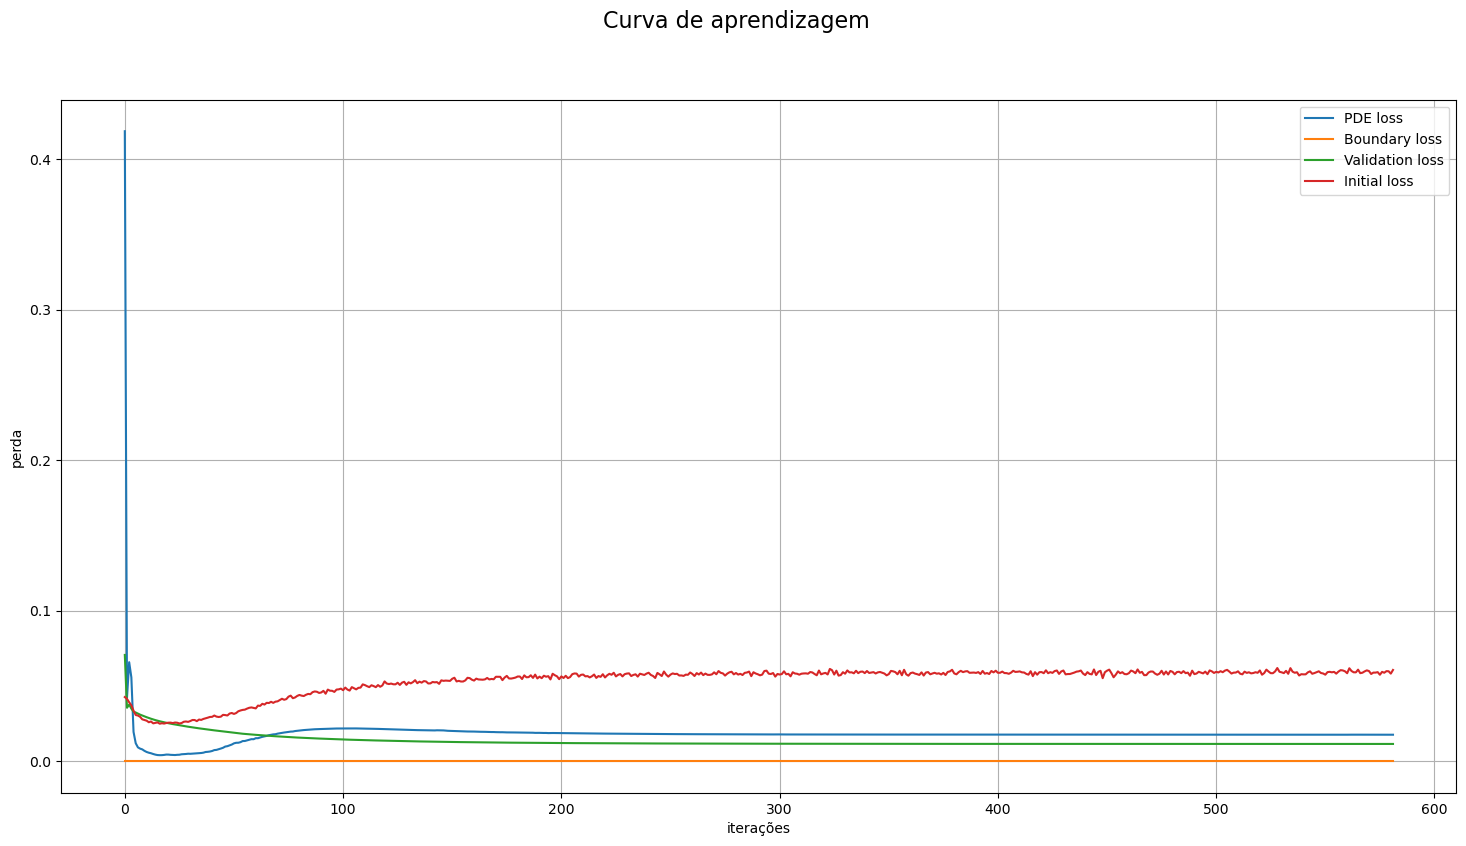

In [89]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_boundary_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)

# ax.plot(
#     range(len(C_data_loss_it.cpu().numpy())),
#     C_data_loss_it.cpu().numpy(),
#     label="Data loss",
# )

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

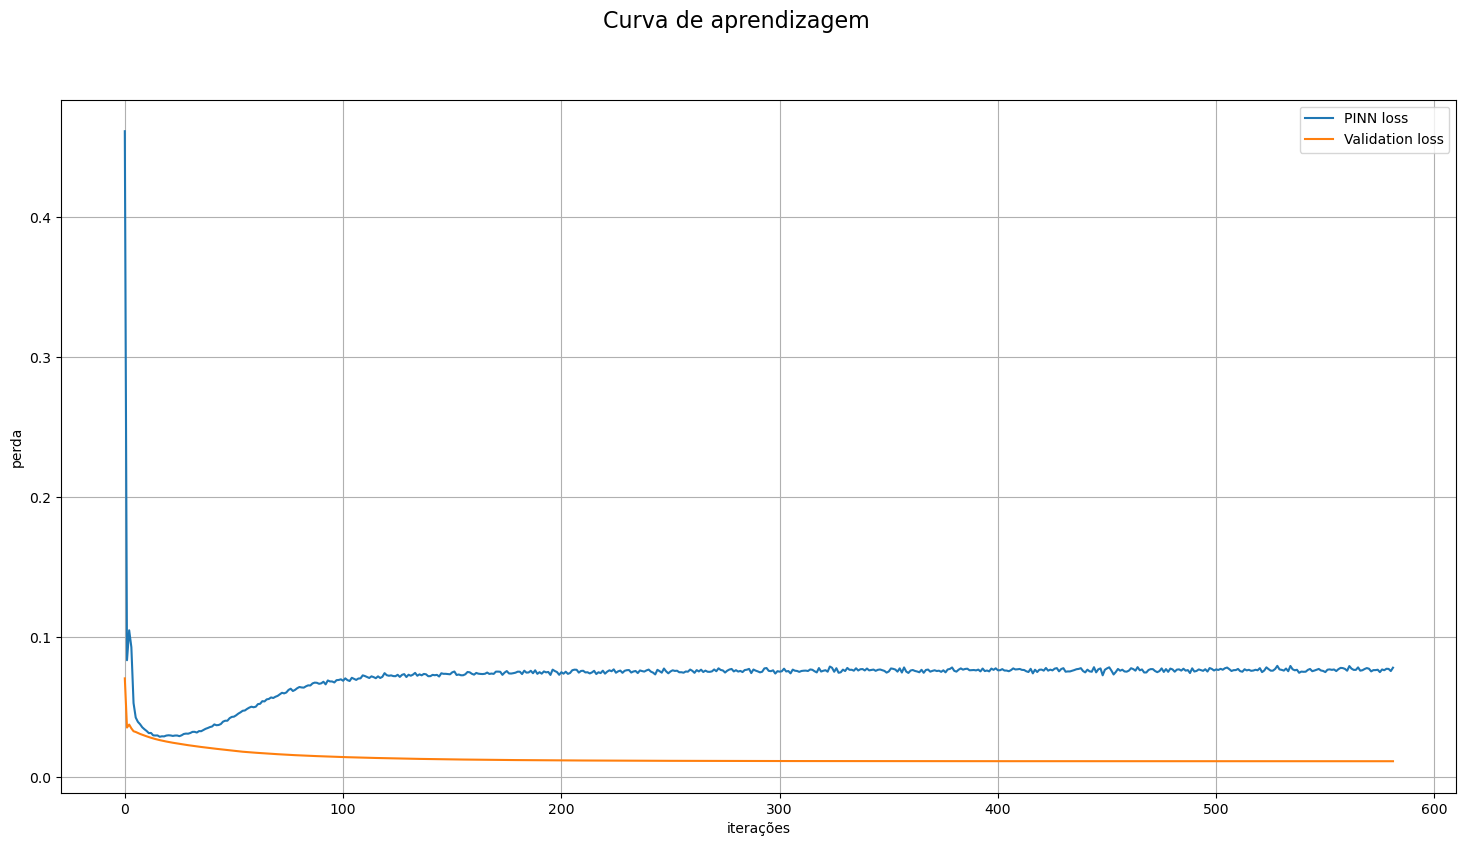

In [90]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy(),
    # + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [91]:
mesh = torch.cat([t_tc, x_tc], dim=1).to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [92]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

## Plot functions

In [93]:
import matplotlib.animation as animation


def plot_comparison(
    size_t, size_x, t_dom, x_dom, Cb, Cn, Cb_pinn, Cn_pinn, leu_source_points
):

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    # t_np, x_np, Cb, Cn, source_index already defined
    # source_index is assumed to be an array of x positions only (1D or Nx1)

    time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    colors = plt.cm.viridis(np.linspace(0, 1, len(time_plot)))

    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[0, 0].plot(
            x_np,
            Cb[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 0].set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    axes[0, 0].set_ylabel("$C_p$", fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[0, 1].plot(
            x_np,
            Cn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 1].set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    axes[0, 1].set_xlabel("x", fontsize=12)
    axes[0, 1].set_ylabel("$C_n$", fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle="--", alpha=0.5)

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[1, 0].plot(
            x_np,
            Cb_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 0].set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    axes[1, 0].set_ylabel("$C_p$", fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[1, 1].plot(
            x_np,
            Cn_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 1].set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    axes[1, 1].set_xlabel("x", fontsize=12)
    axes[1, 1].set_ylabel("$C_n$", fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cb,
    Cn,
    Cb_pinn,
    Cn_pinn,
    leu_source_points,
    delta_t,
    frame_time,
    name="evolucao_1D",
    show=False,
):
    """
    Gera uma animação que mostra a evolução de Cp e Cn em 1D ao longo do tempo.
    Parametros:
        size_t, size_x: nº de pontos no tempo e espaço
        t_dom, x_dom: domínios (lista ou tupla [min, max] para tempo e espaço)
        Cb, Cn: arrays de shape (size_t, size_x) com valores de Cp e Cn
        leu_source_points: array booleano (ou 0/1) indicando onde há fontes (mesmo shape de x ou Nx1).
    """

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    # Converte leu_source_points para índices (caso seja um array Nx1 de 0/1)
    # Se já estiver pronto, pode ajustar conforme sua lógica
    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Cria figura e eixos
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    # Primeiro subplot: Cp
    ax_cp = axes[0, 0]
    (line_cp,) = ax_cp.plot([], [], "b-", lw=2, alpha=0.85, label="Cp")
    ax_cp.set_ylabel("$C_p$")
    ax_cp.set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    ax_cp.grid(True, linestyle="--", alpha=0.5)
    ax_cp.set_xlim(0, 1)
    ax_cp.set_ylim(0, np.max(Cb) * 1.1)
    ax_cp.legend()

    # Segundo subplot: Cn
    ax_cn = axes[0, 1]
    (line_cn,) = ax_cn.plot([], [], "g-", lw=2, alpha=0.85, label="Cn")
    sc_cn = ax_cn.scatter(
        x_np[source_index],
        np.zeros_like(source_index),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )
    ax_cn.set_xlabel("x", fontsize=12)
    ax_cn.set_ylabel("$C_n$")
    ax_cn.set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    ax_cn.grid(True, linestyle="--", alpha=0.5)
    ax_cn.set_xlim(0, 1)
    ax_cn.set_ylim(0, np.max(Cn) * 1.1)
    ax_cn.legend()

    # Primeiro subplot: Cp_pinn
    ax_cp_pinn = axes[1, 0]
    (line_cp_pinn,) = ax_cp_pinn.plot([], [], "b-", lw=2, alpha=0.85, label="Cp_pinn")
    ax_cp_pinn.set_ylabel("$C_p$")
    ax_cp_pinn.set_title("$C_p$ ao longo de x, PINN", fontsize=14)
    ax_cp_pinn.grid(True, linestyle="--", alpha=0.5)
    ax_cp_pinn.set_xlim(0, 1)
    ax_cp_pinn.set_ylim(0, np.max(Cb) * 1.1)
    ax_cp_pinn.legend()

    # Segundo subplot: Cn_pinn
    ax_cn_pinn = axes[1, 1]
    (line_cn_pinn,) = ax_cn_pinn.plot([], [], "g-", lw=2, alpha=0.85, label="Cn_pinn")
    sc_cn_pinn = ax_cn_pinn.scatter(
        x_np[source_index],
        np.zeros_like(source_index),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )
    ax_cn_pinn.set_xlabel("x", fontsize=12)
    ax_cn_pinn.set_ylabel("$C_n$")
    ax_cn_pinn.set_title("$C_n$ ao longo de x, PINN", fontsize=14)
    ax_cn_pinn.grid(True, linestyle="--", alpha=0.5)
    ax_cn_pinn.set_xlim(0, 1)
    ax_cn_pinn.set_ylim(0, np.max(Cn) * 1.1)
    ax_cn_pinn.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Função para inicializar a animação
    def init():
        line_cp.set_data([], [])
        line_cn.set_data([], [])
        line_cp_pinn.set_data([], [])
        line_cn_pinn.set_data([], [])
        return line_cp, line_cn, line_cp_pinn, line_cn_pinn, sc_cn, sc_cn_pinn

    # Função de atualização a cada frame
    def update(frame):
        # frame varia de 0 até size_t-1
        cp_vals = Cb[frame].squeeze()  # shape (size_x,)
        cn_vals = Cn[frame].squeeze()
        cp_vals_pinn = Cb_pinn[frame].squeeze()  # shape (size_x,)
        cn_vals_pinn = Cn_pinn[frame].squeeze()

        # Atualiza as linhas
        line_cp.set_data(x_np, cp_vals)
        line_cn.set_data(x_np, cn_vals)
        line_cp_pinn.set_data(x_np, cp_vals_pinn)
        line_cn_pinn.set_data(x_np, cn_vals_pinn)

        # Atualiza posições dos scatters se necessário (aqui, continua em 0)
        sc_cn.set_offsets(
            np.column_stack((x_np[source_index], np.zeros_like(source_index)))
        )

        sc_cn_pinn.set_offsets(
            np.column_stack((x_np[source_index], np.zeros_like(source_index)))
        )

        # Ajusta título (opcional) para mostrar tempo
        ax_cp.set_title(f"$C_p$ ao longo de x, t = {t_np[frame]:.2f}")
        ax_cn.set_title(f"$C_n$ ao longo de x, t = {t_np[frame]:.2f}")

        return line_cp, line_cn, line_cp_pinn, line_cn_pinn, sc_cn

    frames_indices = range(0, size_t, delta_t)

    # Cria animação
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames_indices,  # total de frames = nº de instantes de tempo
        init_func=init,
        blit=True,  # se quiser performance, use True, mas requer cuidado
        interval=frame_time,  # interval em ms entre frames
    )

    # Salvar como vídeo MP4 (necessita FFmpeg instalado):

    if show:
        plt.show()

    ani.save("fvm_animations/" + name + ".mp4", fps=5)

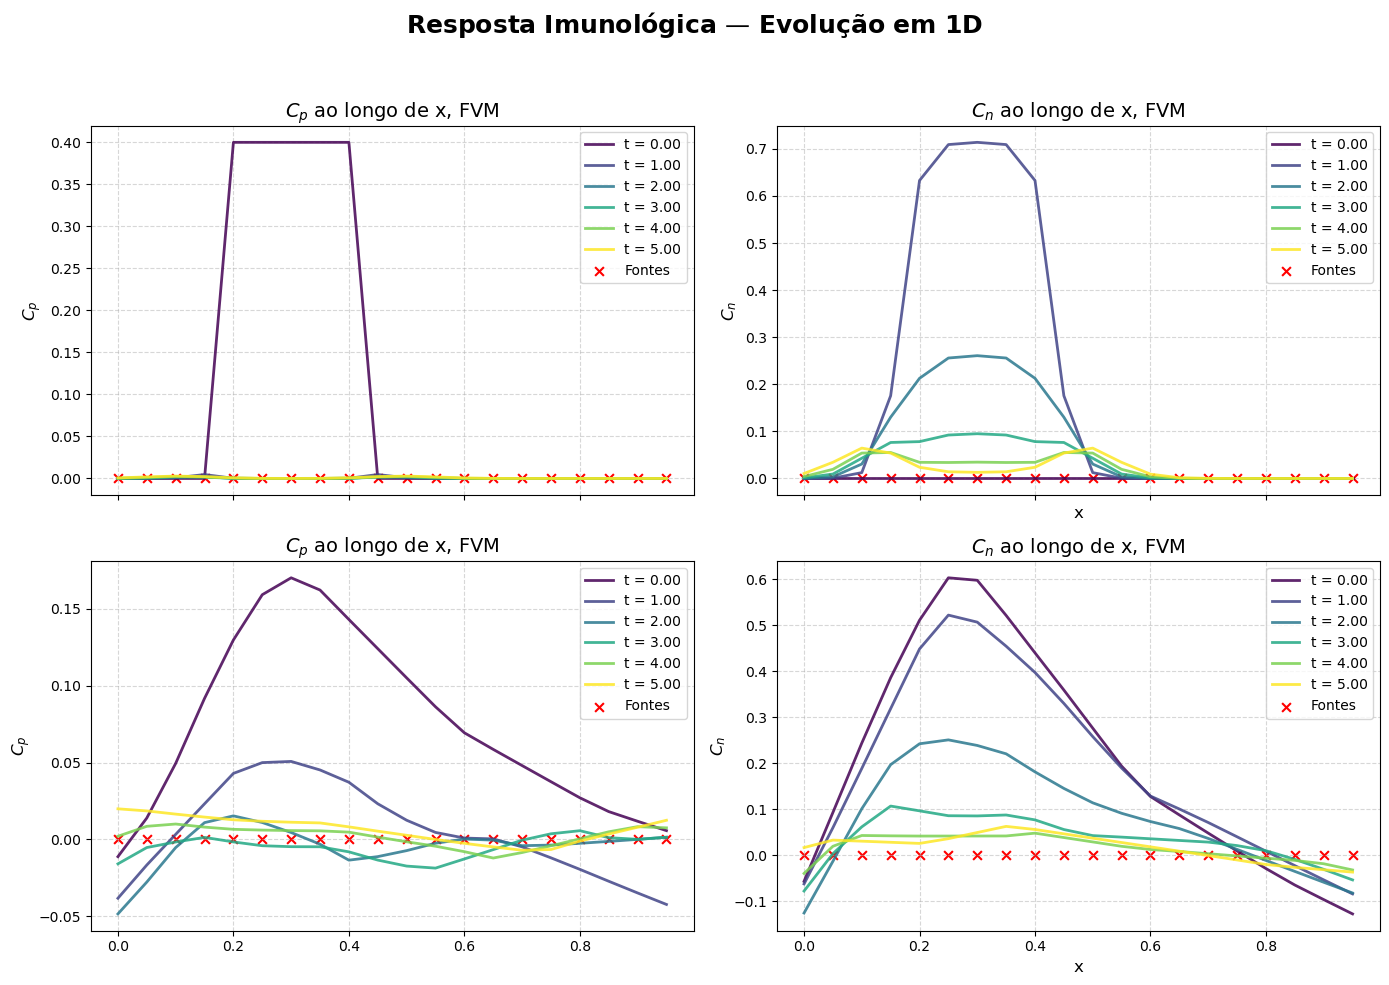

In [94]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


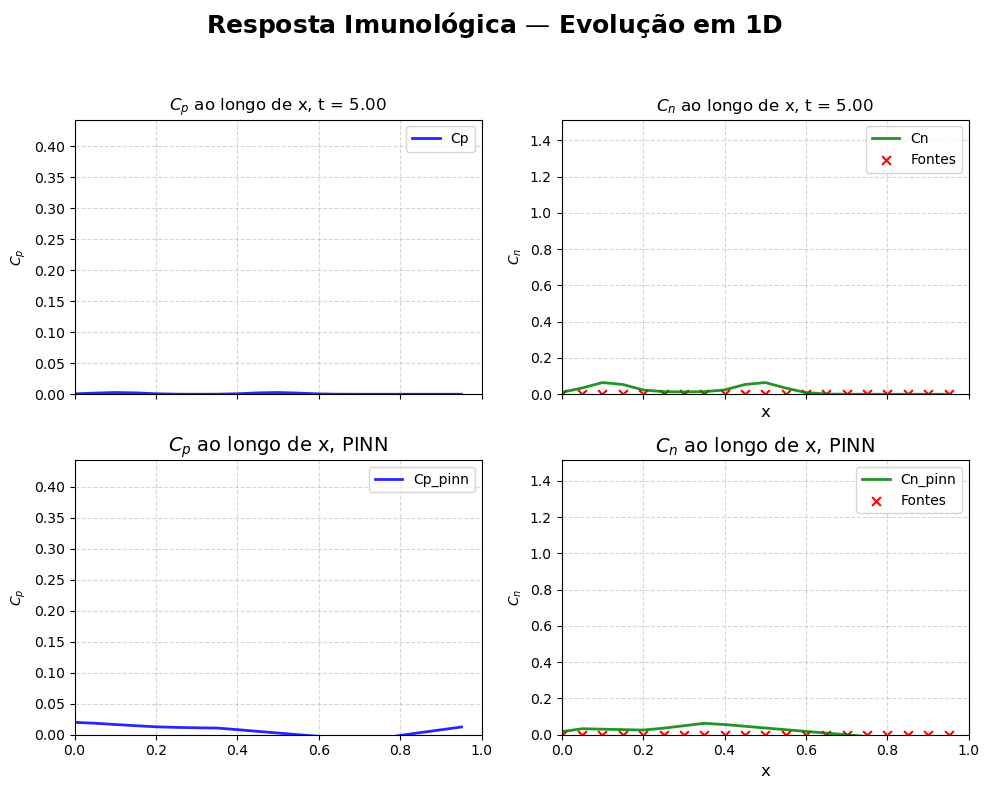

In [95]:

animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__",
)

## Saving model weights and biases

In [94]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([8, 2])
0.bias 	 torch.Size([8])
2.weight 	 torch.Size([32, 8])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([8, 32])
4.bias 	 torch.Size([8])
6.weight 	 torch.Size([32, 8])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [95]:
import os

pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [96]:
import torch
import pickle as pk
import argparse
import os
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)


arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

decay_rate = 0.9985
n_epochs = 300
val = 0.2
batch_size = int(len(t_tc) * (1 - val) / 10)
lr_rate = 6e-4

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=reduced_t_tc,
    x_tc=reduced_x_tc,
    y_tc=reduced_y_tc,
    target=reduced_target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=val,
    tolerance=0.02,
    patience=20,
    normalize=True,
    lr_rate=lr_rate,
)


(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pinn_file = (
    "decay_rates_{:.4}__lr_rates_{:.4}__arch_".format(decay_rate, lr_rate) + arch_str
)

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/C_pde_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_pde_loss_it.cpu().numpy(), openfile)

with open("learning_curves/C_boundary_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_boundary_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_initial_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_initial_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_data_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_data_loss_it.cpu().numpy(), openfile)


with open("learning_curves/val_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(val_loss_it.cpu().numpy(), openfile)

del model
del trainer

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1

device: cuda
Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 801 but got size 800 for tensor number 2 in the list.

# Evaluation setup

In [1]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [2]:
def load_model(file_name, device):
    cwd = os.getcwd()

    arch_str = (
        ("__")
        .join(file_name.split("/")[-1].split(".pt")[0].split("__")[2:])
        .split("arch_")[-1]
    )

    model = generate_model(arch_str).to(device)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [3]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda


In [40]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

t_scaler = Scaler()
x_scaler = Scaler()
y_scaler = Scaler()
target_scaler = Scaler()

t_scaler.fit(t_tc)
x_scaler.fit(x_tc)
y_scaler.fit(y_tc)
target_scaler.fit(target)

norm_t_tc = t_scaler.normalize(t_tc)
norm_x_tc = x_scaler.normalize(x_tc)
norm_y_tc = y_scaler.normalize(y_tc)
norm_target = target_scaler.normalize(target)

for nn_num, nn_file in enumerate(nn_list[0:3]):

    if nn_file.split(".")[-1] == "pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")

        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = torch.cat([norm_t_tc, norm_x_tc, norm_y_tc], dim=1).to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = (
                    speed_up_obj[i]["serial_time"] / pinn_time
                )

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - norm_target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])

            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = norm_target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print(
                "Speed Up: {} +/-{}".format(
                    output["mean_speed_up"], output["std_speed_up"]
                )
            )
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 23289
PINN: decay_rates_0.95__lr_rates_0.0001__arch_Tanh--16__Elu--8__Sigmoid--16__
Already evaluated

2 of 23289
PINN: decay_rates_0.9745__lr_rates_0.001__arch_Elu--32__Elu--8__Elu--16__
Already evaluated

3 of 23289
PINN: decay_rates_0.95__lr_rates_0.001__arch_Sigmoid--16__ReLU--32__SiLU--16__
Already evaluated


# Printing simulations

In [31]:
import matplotlib.pyplot as plt

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)

In [32]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [34]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

In [35]:
Cl_target_np.shape

(10001, 20, 20)

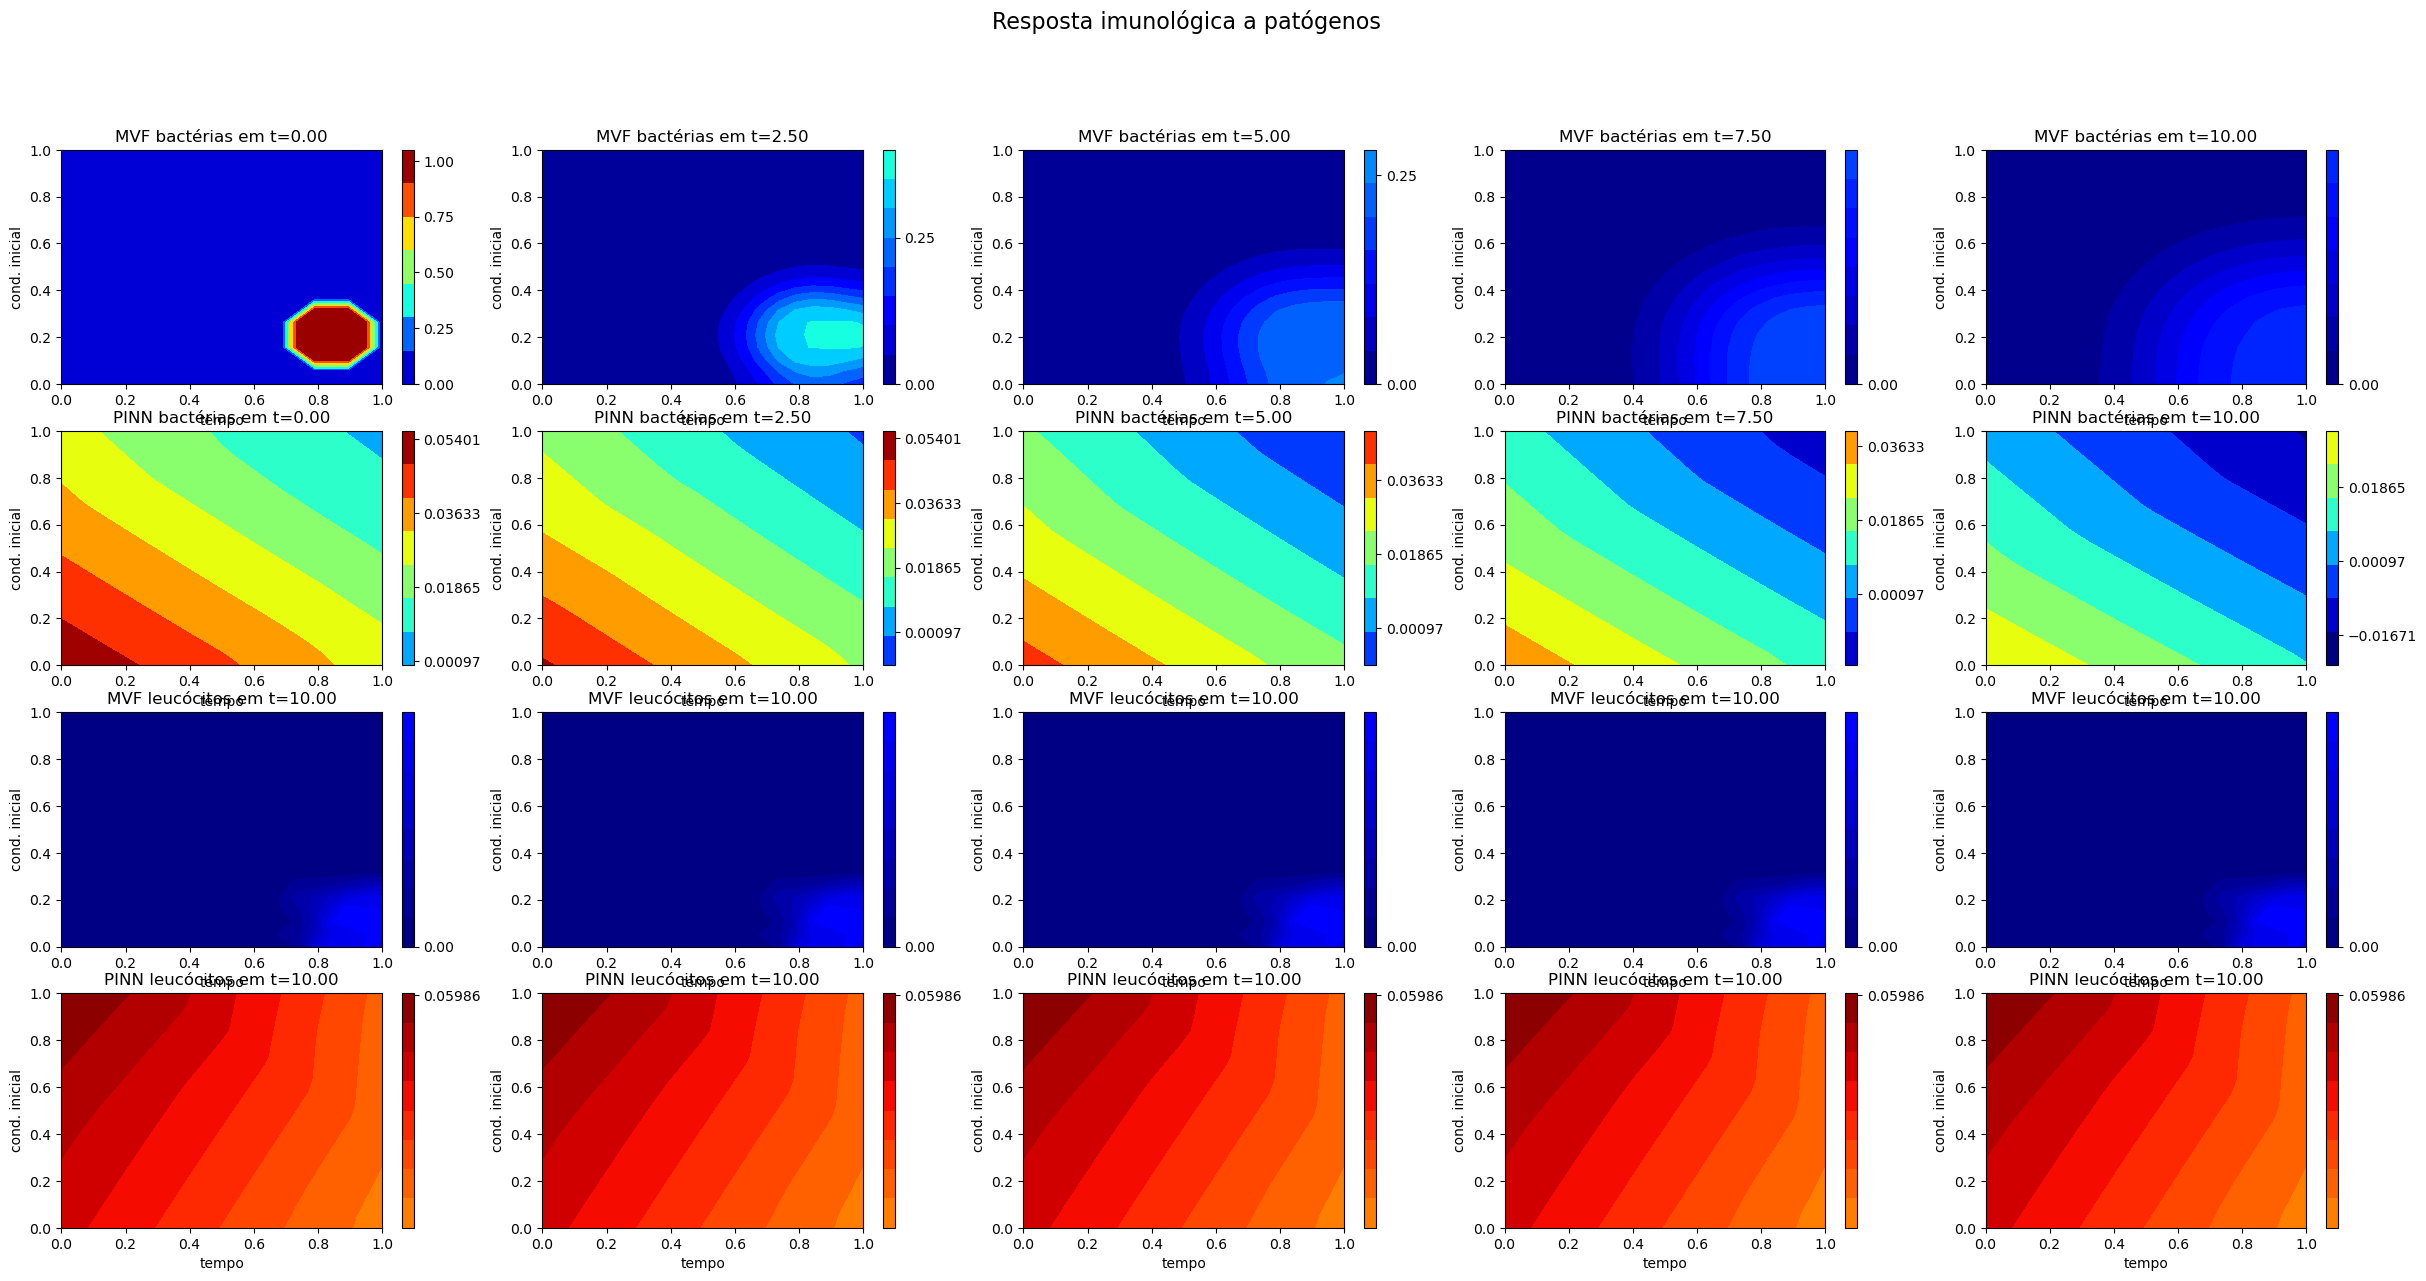

In [ ]:
t = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_target_np)
    vmax = np.max(Cp_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF bactérias em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN bactérias em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_target_np)
    vmax = np.max(Cl_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF leucócitos em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN leucócitos em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [21]:
from glob import glob

list_nn_parameters = glob("nn_parameters/*")

list_learning_curves = glob("learning_curves/*")

list_pinn_sim = glob("pinn_sim/*")